# Importando dependências globais

In [1]:
### Configuração do Ambiente Google Colab ###
import os
COLAB_PATH = '/content/SBRC-Hackathon-5G-Dataset-Challenge'
PWD_PATH = f'{COLAB_PATH}/challenges'
if os.path.exists('/content') and not os.path.exists(f'{COLAB_PATH}/README.md'):
    !pip install --quiet pandas==1.5.3 numpy==1.22.4 scikit-learn==1.2.2 seaborn==0.12.2 plotly==5.14.1
    !git clone --quiet --depth=1 https://github.com/alexandrekaihara/SBRC-Hackathon-5G-Dataset-Challenge.git {COLAB_PATH}
if os.path.exists(PWD_PATH):
    os.chdir(PWD_PATH)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 65.1 MB/s eta 0:00:00


In [2]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances

from datetime import datetime
from math import radians
import json
from urllib.parse import urlparse, parse_qsl
import random

random.seed(42)
pd.set_option('display.max_columns', None)

def count_decimal_places(num):
    str_num = str(num)
    if '.' in str_num:
        return len(str_num) - str_num.index('.') - 1
    else:
        return 0

pd.set_option('display.float_format', lambda x: '{:.{}f}'.format(x, min(count_decimal_places(x), 6)))

def pd_insert_beside(df, column_name, value):
    df.insert(df.columns.get_loc(value.name) + 1, column_name, value)

## Carregando os dados

In [3]:
DATA_PATH_PREFIX = '../datasets'
MOSAICO_PATH = os.path.join(DATA_PATH_PREFIX, 'mosaico')
GNETTRACKPRO_PATH = os.path.join(DATA_PATH_PREFIX, 'g-nettrack-pro')
YOUTUBE_QOE_PATH = os.path.join(DATA_PATH_PREFIX, 'youtube-qoe')

### Mosaico

In [4]:
datasets = [ os.path.join(MOSAICO_PATH, file) for file in os.listdir(MOSAICO_PATH) ]

ERBs = pd.concat([ pd.read_csv(dataset, encoding='iso-8859-1', low_memory=False) for dataset in datasets ], ignore_index=True).copy()
ERBs.replace({ 'Tecnologia': { 'NR ': 'NR', 'WDCMA': 'WCDMA' } }, inplace=True)
pd_insert_beside(ERBs, 'Tecnologia_gen', ERBs.Tecnologia.map({ 'GSM': '2G', 'WCDMA': '3G', 'LTE': '4G', 'NR': '5G' }))
ERBs.Azimute = ERBs.Azimute.str.replace(',', '.').replace('V', np.nan).astype(np.float64)
pd_insert_beside(ERBs, 'Azimute_rad', ERBs.Azimute.apply(lambda val: val * np.pi/180))
ERBs.head(5)

Status.state            NomeEntidade    NumFistel  NumServico     NumAto  \
0   LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146447          10 17012008.0   
1   LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146447          10 35312011.0   
2   LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146447          10 35312011.0   
3   LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146447          10 35312011.0   
4   LIC-LIC-01  TELEFONICA BRASIL S.A.  50409146447          10 35312011.0   

   NumEstacao               EnderecoEstacao EndComplemento SiglaUf  \
0      122700  Rua Manoel Duque de Carvalho            NaN      SP   
1      122700  Rua Manoel Duque de Carvalho            NaN      SP   
2      122700  Rua Manoel Duque de Carvalho            NaN      SP   
3      122700  Rua Manoel Duque de Carvalho            NaN      SP   
4      122700  Rua Manoel Duque de Carvalho            NaN      SP   

   CodMunicipio DesignacaoEmissao Tecnologia Tecnologia_gen tipoTecnologia  \
0       3550308           5M00G9W      WCDMA             3G            NaN   
1       3550308           200KG7W        GSM             2G            NaN   
2       3550308           200KG7W        GSM             2G            NaN   
3       3550308           200KG7W        GSM             2G            NaN   
4       3550308           200KG7W        GSM             2G            NaN   

   meioAcesso  FreqTxMHz  FreqRxMHz  Azimute  Azimute_rad  \
0         NaN     2160.0     1970.0    230.0     4.014257   
1         NaN     1862.5     1767.5    360.0     6.283185   
2         NaN     1862.5     1767.5    130.0     2.268928   
3         NaN     1867.5     1772.5    130.0     2.268928   
4         NaN     1867.5     1772.5    240.0     4.188790   

  CodTipoClasseEstacao ClassInfraFisica CompartilhamentoInfraFisica  \
0                   FB              NaN                         NaN   
1                   FB              NaN                         NaN   
2                   FB              NaN                         NaN   
3                   FB              NaN                         NaN   
4                   FB              NaN                         NaN   

  CodTipoAntena CodEquipamentoAntena GanhoAntena FrenteCostaAntena  \
0           760         002000703518        14.9                25   
1           760         038801200762        17.8                25   
2           760         038801200762        17.8                25   
3           760         038801200762        17.8                25   
4           760         038801200762        17.8                25   

  AnguloMeiaPotenciaAntena AnguloElevacao Polarizacao AlturaAntena  \
0                       70              6           X           41   
1                       65              5           X           39   
2                       65              5           X           39   
3                       65              5           X           39   
4                       65              5           X           39   

  CodEquipamentoTransmissor PotenciaTransmissorWatts  Latitude  Longitude  \
0              018930701882                     39.4 -23.71889  -46.68889   
1              006030301882                     15.8 -23.71889  -46.68889   
2              006030301882                     15.8 -23.71889  -46.68889   
3              006030301882                     15.8 -23.71889  -46.68889   
4              006030301882                     15.8 -23.71889  -46.68889   

  CodDebitoTFI DataLicenciamento DataPrimeiroLicenciamento NumRede  \
0            G        2021-12-24                1999-12-10     NaN   
1            G        2021-12-24                1999-12-10     NaN   
2            G        2021-12-24                1999-12-10     NaN   
3            G        2021-12-24                1999-12-10     NaN   
4            G        2021-12-24                1999-12-10     NaN   

             _id DataValidade  NumFistelAssociado NomeEntidadeAssociado  
0  4d5c019f58e6a   2023-04-30                 NaN

### G-NetTrack

In [5]:
datasets = [ os.path.join(GNETTRACKPRO_PATH, file) for file in os.listdir(GNETTRACKPRO_PATH) ]

datasetsData = []
labels = ["walking", "subway", "driving", "indoor"]
for dataset in datasets:
  dt = pd.read_csv(dataset, sep='\t', low_memory=False, on_bad_lines='warn')
  label = [label for label in labels if label in dataset]
  if len(label) > 0:
    label = label[0]
    dt['label'] = label

    datasetsData.append(dt)

gnetDf = pd.concat(datasetsData).copy()
gnetDf.drop(gnetDf.loc[gnetDf.Timestamp == 'Timestamp'].index, inplace=True)
gnetDf.Timestamp = pd.to_datetime(gnetDf.Timestamp, format='%Y.%m.%d_%H.%M.%S')
pd_insert_beside(gnetDf, 'Timestamp_seconds', gnetDf.Timestamp.astype(int) / 10**9)
gnetDf.sort_values('Timestamp', inplace=True, ignore_index=True)
gnetDf.replace({
    'Altitude': { '--': np.nan },
    'CHARGING': { 'true': True, 'false': False },
    **{ k: { '--': np.nan } for k in ['Longitude', 'Latitude', 'NetworkTech', 'Accuracy'] },
    **{ k: { '-': np.nan } for k in ['CQI', 'SNR', 'Qual', 'LTERSSI'] },
}, inplace=True)
gnetDf = gnetDf.astype({
    **{ k: 'string' for k in ['NetworkTech', 'NetworkMode', 'Location', 'State', 'EVENT', 'CGI', 'Node', 'CellID', 'LAC', 'Operatorname', 'Operator', 'IP'] },
    **{ k: np.float64 for k in ['Longitude', 'Latitude', 'Speed', 'Accuracy', 'SNR', 'Level', 'Qual', 'CQI', 'LTERSSI', 'ARFCN', 'DL_bitrate', 'UL_bitrate', 'PSC', 'Altitude', 'Height'] },
    **{ k: np.int32 for k in ['BATTERY'] },
})

gnetDf.replace({
    'Altitude': { 0: np.nan },
    'Height': { 0: np.nan, -10000: np.nan },
    'Speed': { -99: np.nan },
}, inplace=True)
gnetDf




Skipping line 13484: expected 260 fields, saw 390
Skipping line 13485: expected 260 fields, saw 390
Skipping line 13486: expected 260 fields, saw 390
Skipping line 13487: expected 260 fields, saw 390
Skipping line 13488: expected 260 fields, saw 390
Skipping line 13489: expected 260 fields, saw 390
Skipping line 13490: expected 260 fields, saw 390
Skipping line 13491: expected 260 fields, saw 390
Skipping line 13492: expected 260 fields, saw 390
Skipping line 13493: expected 260 fields, saw 390
Skipping line 13494: expected 260 fields, saw 390
Skipping line 13495: expected 260 fields, saw 390
Skipping line 13496: expected 260 fields, saw 390
Skipping line 13497: expected 260 fields, saw 390
Skipping line 13498: expected 260 fields, saw 390
Skipping line 13499: expected 260 fields, saw 390
Skipping line 13500: expected 260 fields, saw 390
Skipping line 13501: expected 260 fields, saw 390
Skipping line 13502: expected 260 fields, saw 390
Skipping line 13503: expected 260 fields, saw 390


Timestamp  Timestamp_seconds  Longitude   Latitude  Speed  \
0     2023-01-21 14:44:46       1674312286.0        NaN        NaN    NaN   
1     2023-01-21 14:44:46       1674312286.0        NaN        NaN    NaN   
2     2023-01-21 14:44:47       1674312287.0        NaN        NaN    NaN   
3     2023-01-21 14:44:48       1674312288.0        NaN        NaN    NaN   
4     2023-01-21 14:44:49       1674312289.0        NaN        NaN    NaN   
...                   ...                ...        ...        ...    ...   
18341 2023-01-22 22:31:02       1674426662.0 -46.728399 -23.595755    0.0   
18342 2023-01-22 22:31:03       1674426663.0 -46.728399 -23.595755    0.0   
18343 2023-01-22 22:31:04       1674426664.0 -46.728399 -23.595755    0.0   
18344 2023-01-22 22:31:05       1674426665.0 -46.728399 -23.595755    0.0   
18345 2023-01-22 22:31:05       1674426665.0 -46.728399 -23.595755    0.0   

      Operatorname Operator              CGI Cellname    Node CellID    LAC  \
0         CLARO_BR    72405  724056481100018      NaN  113726     18  64811   
1         CLARO_BR    72405  724056481100018      NaN  113726     18  64811   
2         CLARO_BR    72405  724056481100018      NaN  113726     18  64811   
3         CLARO_BR    72405  724056481100017      NaN  113726     17  64811   
4         CLARO_BR    72405  724056481100017      NaN  113726     17  64811   
...            ...      ...              ...      ...     ...    ...    ...   
18341     CLARO_BR    72405  724054571100003      NaN  111825      3  45711   
18342     CLARO_BR    72405  724054571100003      NaN  111825      3  45711   
18343     CLARO_BR    72405  724054571100003      NaN  111825      3  45711   
18344     CLARO_BR    72405  724054571100003      NaN  111825      3  45711   
18345     CLARO_BR    72405  724054571100003      NaN  111825      3  45711   

      NetworkTech NetworkMode  Level  Qual  SNR  CQI  LTERSSI  ARFCN  \
0              4G         LTE -112.0  -8.0 17.0 14.0    -65.0 1400.0   
1              4G         LTE -110.0  -8.0 16.0 14.0    -61.0 1400.0   
2              4G         LTE -112.0  -8.0 17.0 14.0    -65.0 1400.0   
3              4G         LTE -109.0  -8.0  4.0  6.0    -59.0 1400.0   
4              4G         LTE -109.0  -8.0  4.0  6.0    -59.0 1400.0   
...           ...         ...    ...   ...  ...  ...      ...    ...   
18341          4G         LTE -108.0 -17.0 -2.0 10.0   -109.0 2950.0   
18342          4G         LTE -108.0 -17.0 -2.0 10.0   -109.0 2950.0   
18343          4G         LTE -107.0 -16.0 -2.0 10.0   -105.0 2950.0   
18344          4G         LTE -107.0 -16.0 -2.0 10.0   -105.0 2950.0   
18345          4G         LTE -107.0 -16.0 -2.0 10.0   -105.0 2950.0   

       DL_bitrate  UL_bitrate   PSC  Altitude  Height  Accuracy Location  \
0           119.0        53.0 111.0       NaN     NaN       NaN     <NA>   
1            25.0        29.0 111.0       NaN     NaN       NaN     <NA>   
2            15.0         2.0 111.0       NaN     NaN       NaN     <NA>   
3             0.0         0.0 103.0       NaN     NaN       NaN     <NA>   
4             0.0         0.0 103.0       NaN     NaN       NaN     <NA>   
...           ...         ...   ...       ...     ...       ...      ...   
18341        53.0        56.0 305.0     779.0   779.0       4.0        G   
18342        43.0        29.0 305.0     779.0   779.0       4.0        G   
18343        70.0       158.0 305.0     779.0   779.0       4.0        G   
18344      3309.0       144.0 305.0     779.0   779.0       4.0        G   
18345      3309.0       144.0 305.0     779.0   779.0       4.0        G   

      State PINGAVG PINGMIN PINGMAX PINGSTDEV PINGLOSS TESTDOWNLINK  \
0         D     NaN     NaN     NaN       NaN      NaN          NaN   
1         D     NaN     NaN     NaN       NaN      NaN          NaN   
2         D     NaN     NaN     NaN       NaN      NaN          NaN   
3         D     NaN     NaN     NaN       NaN      NaN          NaN   
4        

# 1º Desafio: Visualização usando o PathsViewer

## Parse para os datasets

In [ ]:
!mkdir paths_viewer

files = [["SubWay","https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-21_244-subway-1.txt"],
         ["Paulista_1", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-21_308-walking-paulista-1.txt"],
         ["Paulista_2", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-21_345-walking-paulista-2.txt"],
         ["São_Paulo_1", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-21_404-indoor-shopping-cidade-sao-paulo-1.txt"],
         ["Paulista_3", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-21_423-walking-paulista-3.txt"],
         ["Starbucks", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-21_435-indoor-starbucks-masp-1.txt"],
         ["Paulista_4", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-21_501-walking-paulista-4.txt"],
         ["Paulista_5", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-21_517-walking-paulista-5.txt"],
         ["Paulista_6", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-21_555-walking-paulista-6.txt"],
         ["Driving_2", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-22_1004-driving-sp-2.txt"],
         ["Driving_1", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-22_933-driving-sp-1.txt"],
         ["Vila Petra", "https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-22_955-indoor-vila-petra-1.txt"]]

for file in files:
    # download the file on the url
    df = pd.read_csv(file[1], sep='	', header=0, on_bad_lines="skip")

    # print(df.head())
    # split Timestamp by "_"
    df['data'] = df['Timestamp'].str.split('_').str[0]
    df['hora'] = df['Timestamp'].str.split('_').str[1]

    # substitui "." por "-" no campo data e hora
    df['data'] = df['data'].str.replace('.', '-')
    df['hora'] = df['hora'].str.replace('.', ':')

    # keep only the Timestamp, data, hora, Latitude, Longitude
    df = df[['Timestamp', 'data', 'hora', 'Latitude', 'Longitude']]

    #export a csv file with the new data
    df.to_csv("./paths_viewer/"+file[0] + ".csv", index=False, header=False)


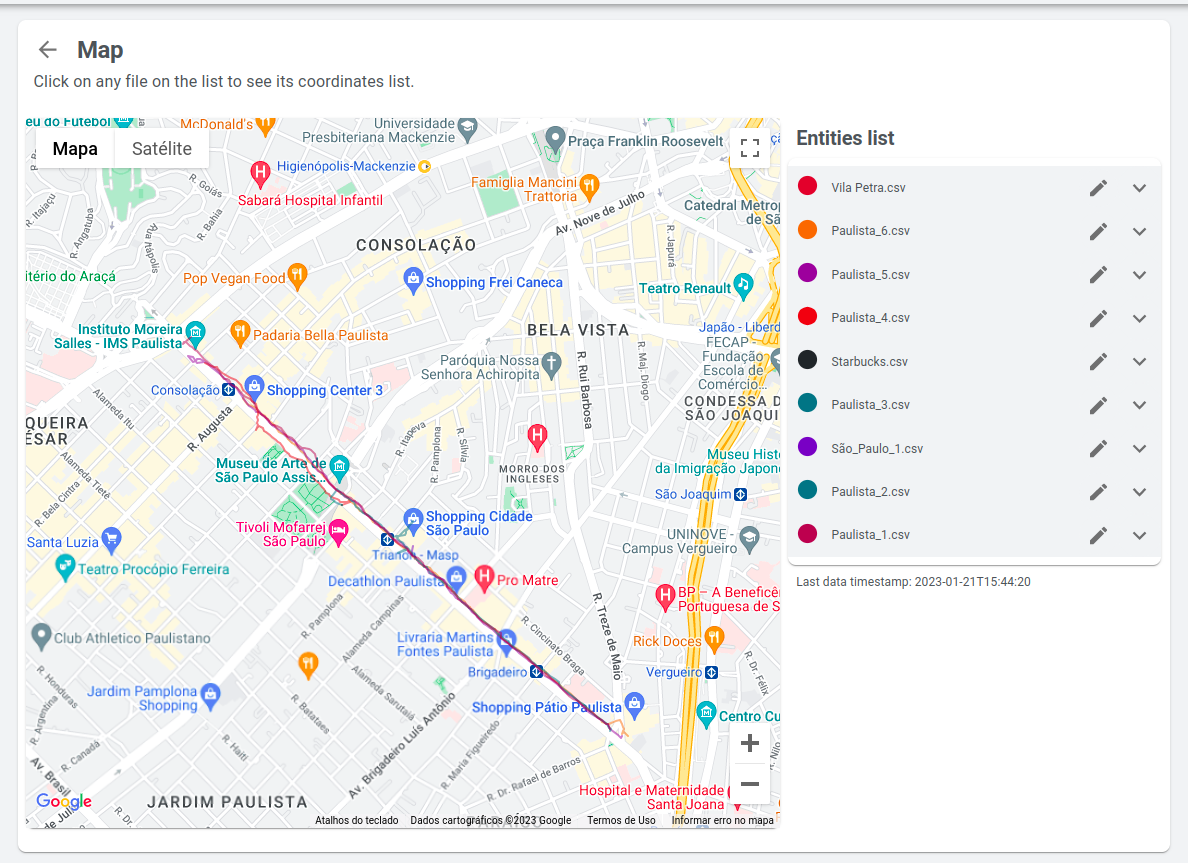

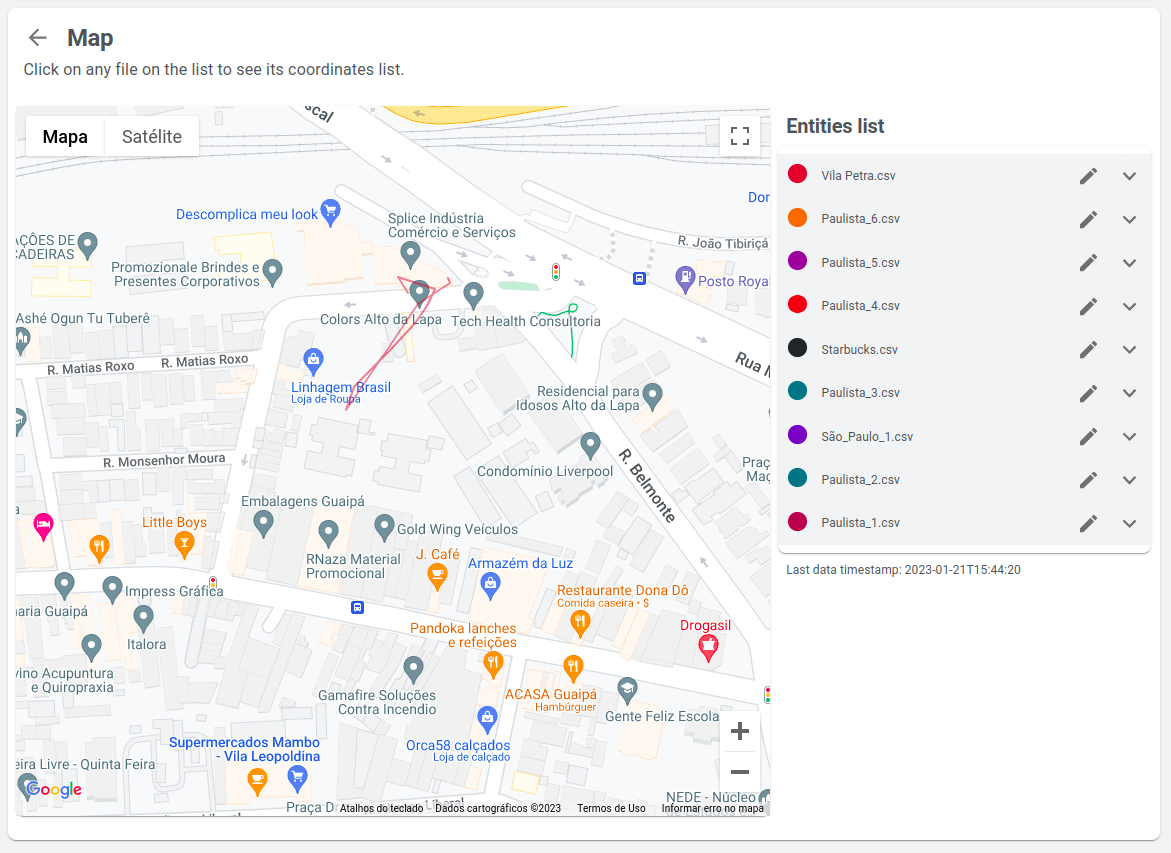

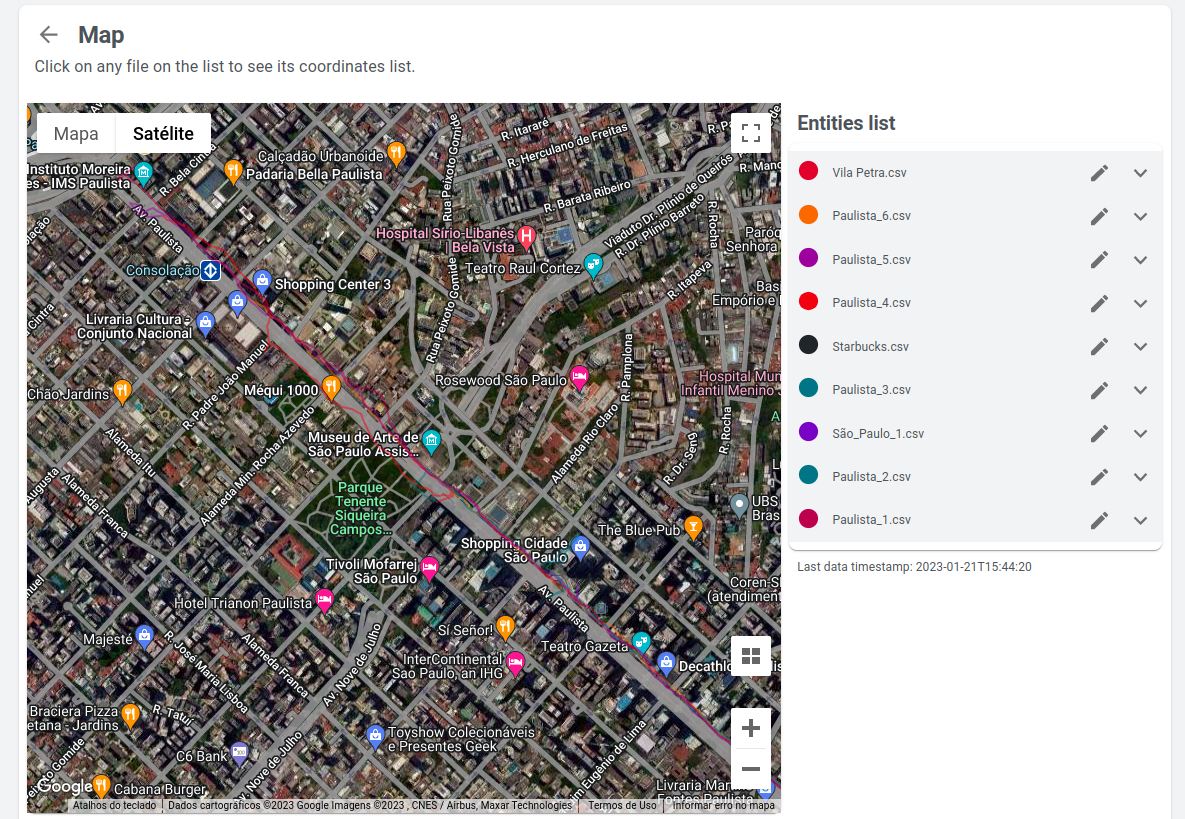

<br> 
**INSIGHTS:**
- **Padrões de movimento:** <br>
A visualização da trajetória do dispositivo pode revelar padrões de movimento, como deslocamentos regulares ou rotas comuns. Isso pode ajudar a identificar rotas preferenciais, comportamentos repetitivos ou áreas frequentemente visitadas. Essa informação pode ser utilizada, por exemplo, por provedoras de internet para entender a demanda de cobertura e banda em cada região.

- **Monitoramento e segurança:** 
<br> 
Visualizar as trajetórias em tempo real pode ser valioso para rastrear veículos, ativos ou pessoas em tempo real, permitindo um acompanhamento eficiente e fornecendo informações para fins de segurança, logística ou gerenciamento de ativos.

- **Detecção de eventos ou incidentes:** 
<br> 
Ao observar as trajetórias em tempo real, é possível identificar eventos ou incidentes anormais. Por exemplo, um dispositivo que desvia de sua rota habitual ou um agrupamento repentino de dispositivos em uma área específica podem indicar situações, como acidentes, congestionamentos ou atividades suspeitas.

<br> 
**SUGESTÕES DE MELHORIA:**

**Experiência de Usuário**
- **Controle de visibilidade de trajetórias:** 
<br> 
Adicionar a opção de ocultar ou mostrar trajetórias específicas, permitindo ao usuário selecionar elementos da lista de entidades para exibir ou ocultar suas trajetórias correspondentes no mapa. Isso pode ser realizado adicionando um botão com a função de mostrar/esconder para cada elemento ou transformar o círculo colorido nesse botão.
- **Navegação direta para trajetórias:** 
<br> 
Implementar a funcionalidade de navegar diretamente para uma trajetória ou coordenada específica ao clicar em um elemento na lista de entidades ou em uma de suas coordenadas, garantindo que ela seja automaticamente centralizada e visível no mapa.
- **Personalização da espessura da linha de trajetória:** 
<br> 
Permitir que os usuários ajustem a espessura da linha que representa as trajetórias, para melhorar a legibilidade e a visualização em diferentes escalas de zoom.
- **Filtrar visualização dos dispositivos por intervalo de tempo:** 
<br> 
Implementar a capacidade de filtrar a visualização dos dispositivos com base em um intervalo de tempo específico. Isso permitiria aos usuários selecionar um momento desejado por meio de um slider ou controle deslizante, exibindo apenas as posições dos dispositivos correspondentes a esse momento específico. Essa funcionalidade ofereceria uma maneira mais precisa de explorar e analisar as trajetórias em momentos específicos, fornecendo um nível adicional de detalhamento e controle na visualização dos dados.

**Features**
- **Calculo da velocidade:** <br>
Utilizando a posição e o tempo, é possível calcular a velocidade dos dispositivos em cada instante. Essa informação pode ser útil para várias aplicações. Por exemplo: <br>
    - Análise da eficiência de trânsito: Ter acesso à velocidade possibilita analisar a eficiência das rotas utilizadas. Comparando as velocidades médias em diferentes trechos da trajetória, seria possível identificar rotas que causam atrasos significativos ou que oferecem oportunidades para melhorias no tempo de percurso.
    - Planejamento e previsão: Com base nas velocidades calculadas, seria possível realizar análises preditivas para prever tempos de chegada, estimar a duração de deslocamentos futuros e fornecer informações úteis para o planejamento logístico, roteirização e agendamento de atividades.


# 2º Desafio: Estimação da Qualidade do sinal

## Preprocessing




In [6]:
dataframe = gnetDf.copy()

### Discretização de Valores Não-Numéricos

A fim de conseguir realizer a regressão em diferentes algoritmos, é necessário converter quaisquer variáveis discretas em valores numéricos discretos, sendo assim, possível incluir estes como variáveis para treinamento.

In [7]:
for column in dataframe.select_dtypes(include=['object', "string", "datetime"]):
    codes, uniques = pd.factorize(dataframe[column])
    dataframe[column] = codes


<ipython-input-7-5e7558f90b9c>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  codes, uniques = pd.factorize(dataframe[column])
<ipython-input-7-5e7558f90b9c>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  codes, uniques = pd.factorize(dataframe[column])
<ipython-input-7-5e7558f90b9c>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  codes, uniques = pd.factorize(dataframe[column])
<ipython-input-7-5e7558f90b9c>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  codes, uniques = pd.factorize(dataframe[column])
<ipython-input-7-5e7558f90b9c>:2: FutureWarning: In a future

### Normalização de Dados

In [8]:
from sklearn import preprocessing

columns_to_exclude = ["Qual", "SNR", "CQI"]
columns_to_normalize = [col for col in dataframe.columns if col not in columns_to_exclude]

dataframe_values = dataframe[columns_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,2))
df_scaled = min_max_scaler.fit_transform(dataframe_values)
dataframe_normalized = pd.DataFrame(df_scaled, columns=columns_to_normalize)

for column in columns_to_exclude:
  dataframe_normalized[column] = dataframe[column] 

display(dataframe_normalized.head(10))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Timestamp  Timestamp_seconds  Longitude  Latitude  Speed  Operatorname  \
0        0.0                0.0        NaN       NaN    NaN           0.0   
1        0.0                0.0        NaN       NaN    NaN           0.0   
2   0.000130           0.000017        NaN       NaN    NaN           0.0   
3   0.000261           0.000035        NaN       NaN    NaN           0.0   
4   0.000391           0.000052        NaN       NaN    NaN           0.0   
5   0.000522           0.000070        NaN       NaN    NaN           0.0   
6   0.000652           0.000087        NaN       NaN    NaN           0.0   
7   0.000783           0.000105        NaN       NaN    NaN           0.0   
8   0.000913           0.000122        NaN       NaN    NaN           0.0   
9   0.001044           0.000140        NaN       NaN    NaN           0.0   

   Operator      CGI  Cellname     Node   CellID  LAC  NetworkTech  \
0       0.0      0.0       0.0 0.024096      0.0  0.0     0.666667   
1       0.0      0.0       0.0 0.024096      0.0  0.0     0.666667   
2       0.0      0.0       0.0 0.024096      0.0  0.0     0.666667   
3       0.0 0.034483       0.0 0.024096 0.105263  0.0     0.666667   
4       0.0 0.034483       0.0 0.024096 0.105263  0.0     0.666667   
5       0.0 0.034483       0.0 0.024096 0.105263  0.0     0.666667   
6       0.0 0.034483       0.0 0.024096 0.105263  0.0     0.666667   
7       0.0 0.034483       0.0 0.024096 0.105263  0.0     0.666667   
8       0.0 0.034483       0.0 0.024096 0.105263  0.0     0.666667   
9       0.0 0.034483       0.0 0.024096 0.105263  0.0     0.666667   

   NetworkMode    Level  LTERSSI    ARFCN  DL_bitrate  UL_bitrate      PSC  \
0          0.0 1.342995 1.548387 0.245726    0.001337    0.085415 0.443114   
1          0.0 1.362319 1.677419 0.245726    0.000281    0.046737 0.443114   
2          0.0 1.342995 1.548387 0.245726    0.000168    0.003223 0.443114   
3          0.0 1.371981 1.741935 0.245726         0.0         0.0 0.411178   
4          0.0 1.371981 1.741935 0.245726         0.0         0.0 0.411178   
5          0.0 1.371981 1.741935 0.245726         0.0         0.0 0.411178   
6          0.0 1.371981 1.741935 0.245726         0.0         0.0 0.411178   
7          0.0 1.381643 1.612903 0.245726         0.0    0.008058 0.411178   
8          0.0 1.381643 1.612903 0.245726    0.003729    0.067687 0.411178   
9          0.0 1.400966 1.741935 0.245726    0.005593    0.193392 0.411178   

   Altitude  Height  Accuracy  Location  State  PINGAVG  PINGMIN  PINGMAX  \
0       NaN     NaN       NaN       0.0    0.0      0.0      0.0      0.0   
1       NaN     NaN       NaN       0.0    0.0      0.0      0.0      0.0   
2       NaN     NaN       NaN       0.0    0.0      0.0      0.0      0.0   
3       NaN     NaN       NaN       0.0    0.0      0.0      0.0      0.0   
4       NaN     NaN       NaN       0.0    2.0      0.0      0.0      0.0   
5       NaN     NaN       NaN       0.0    2.0      0.0      0.0      0.0   
6       NaN     NaN       NaN       0.0    2.0      0.0      0.0      0.0   
7       NaN     NaN       NaN       0.0    0.0      0.0      0.0      0.0   
8       NaN     NaN       NaN       0.0    0.0      0.0      0.0      0.0   
9       NaN     NaN       NaN       0.0    0.0      0.0      0.0      0.0   

   PINGSTDEV  PINGLOSS  TESTDOWNLINK  TESTUPLINK  TESTDOWNLINKMAX  \
0        0.0       0.0           0.0         0.0              0.0   
1        0.0       0.0           0.0         0.0              0.0   
2        0.0       0.0           0.0         0.0              0.0   
3        0.0       0.0           0.0         0.0              0.0   
4        0.0       0.0           0.0         0.0              0.0   
5        0.0       0.0           0.0         0.0              0.0   
6        0.0       0.0           0.0         0.0              0.0   
7        0.0       0.0           0.0         0.0              0.0   
8        0.0       0.0           0.0         0.0        

### Split Dataset

Fizemos uma separação arbitrária de 80-20 de separação do dataset para treinamento e teste.

In [9]:
from sklearn.model_selection import train_test_split

featCol = ['Longitude', 'Latitude', 'Altitude', "NetworkMode", "Level", "TA"]
predictCol = ['Qual']

df = dataframe_normalized[featCol + predictCol].dropna()

# selecionando os atributos (x) e os rótulos (y) para a predição
x = df.reindex(columns=featCol)
y = df.reindex(columns=predictCol)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

display(X_train)

Longitude  Latitude  Altitude  NetworkMode    Level       TA
2027    1.831843  0.786874  1.048544          0.0 1.623188    0.375
13499   1.686617  0.948083  1.194175          1.6 1.545894    0.375
1857    1.805229  0.814827  1.048544          1.6 1.584541 0.458333
12761   1.787799  0.834931  1.106796          1.6 1.642512 0.458333
18063   0.381451  0.190275  0.281553          0.0 1.555556      0.5
...          ...       ...       ...          ...      ...      ...
11959   1.901368  0.709878  1.038835          1.6 1.594203    0.375
12639   1.804845  0.816093  1.106796          1.6 1.642512 0.416667
6065    1.760342  0.862908  1.009709          1.6 1.768116 0.291667
1535    1.757389  0.865795  1.048544          1.6 1.719807 0.291667
16564   0.539484  1.454824  0.436893          0.0 1.342995 0.333333

[14061 rows x 6 columns]

## Model

Dado que o problema refere-se a um problema de regressão, escolhemos algoritmos de Machine Learning (ML) que fossem especializados em regressão para obter a predição de valores não discretos.

Optamos por incluir não apenas a avaliação de um algoritmo, mas de três ao mesmo tempo. Dentre eles o Support Vector Regression (SVR), Decision Tree Regressor (DTR) e o famoso Random Forest Regressor (RFR).

### Support Vector Regressor (SVR)


In [10]:
from sklearn.svm import SVR

# Creating and training the SVR model
SVR = SVR(kernel='rbf')  
SVR.fit(X_train, y_train.values.ravel())

# Making predictions
y_pred_svr = SVR.predict(X_test)

### Decision Tree Regressor (DTR)

A vantagem do uso de Decision Tree Regression é um modelo de ML que é uma white box, uma gende vantagem comparada a SVR e o RFR.





In [11]:
from sklearn.tree import DecisionTreeRegressor

DTR = DecisionTreeRegressor()
DTR.fit(X_train, y_train)

# Making predictions
y_pred_dtr = DTR.predict(X_test)

### Random Forest Regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor(n_estimators=25, random_state=42)
RFR.fit(X_train, y_train.values.ravel())

# Making predictions
y_pred_rfr = RFR.predict(X_test)

## Resultados

### Funções

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, learning_curve, ShuffleSplit
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.exceptions import ModelError

# Evaluating the model
def mean_errors(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  print("Mean Squared Error:", mse)

  mae = mean_absolute_error(y_test, y_pred)
  print("Mean Absolute Error:", mae)

def R2Score(X_train, y_train, model):
  display(Markdown(f'treinamento: {model.score(X_train, y_train)}'))
  display(Markdown(f'teste: {model.score(X_test, y_test)}'))

def col_importances(model):
  importances = list(model.feature_importances_)
  for i in range(len(x.columns)):
      display(Markdown(f'{x.columns[i]}: {importances[i]:.2f}'))

def get_cross_val(X_train, y_train, model):
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=5, scoring=make_scorer(mean_absolute_error))
  print("Cross-Validation Scores:", cv_scores)

def plot_learning_curve(X_train, y_train, model):
  # Plot the learning curve
  train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train.values.ravel(), cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10))
  train_scores_mean = -np.mean(train_scores, axis=1)
  test_scores_mean = -np.mean(test_scores, axis=1)

  plt.figure()
  plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
  plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
  plt.xlabel('Training examples')
  plt.ylabel('Negative Mean Absolute Error')
  plt.legend(loc='best')
  plt.title('Learning Curve')
  plt.show()

def plot_dispersion(X_train, y_train, model):
  # Create dispersion plots
  visualizer = ResidualsPlot(model)
  visualizer.fit(X_train, y_train.values.ravel())
  visualizer.score(X_train, y_train.values.ravel())
  visualizer.show()

def plot_scatter_plot(y_test, y_pred):
  # Scatter Plot
  plt.axline((0, 0), slope=1, color="red", linestyle=(0, (5, 5)))
  plt.scatter(y_test, y_pred)

  # Set labels and title
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.title('Scatter Plot: True Values vs Predicted Values')

  # Show the plot
  plt.show()

### Discussões

In [14]:
print("Support Vector Regressor:")
mean_errors(y_test, y_pred_svr)

print("\nDecision Tree Regressor:")
mean_errors(y_test, y_pred_dtr)

print("\nRandom Forest Regressor:")
mean_errors(y_test, y_pred_rfr)

Support Vector Regressor:
Mean Squared Error: 4.73403138161634
Mean Absolute Error: 1.5132183716940335

Decision Tree Regressor:
Mean Squared Error: 1.2267223935311653
Mean Absolute Error: 0.5018895369619316

Random Forest Regressor:
Mean Squared Error: 1.1159720180159598
Mean Absolute Error: 0.5935253733635206


Observamos que o Support Vector Regressor não obteve resultados muito bons comparado aos demais modelos dado o alto valor erro da predição. Nada se pode afirmar sobre o DTR e o RFR, pois obtiveram erros muito próximos e a diferença não é significativa.

In [15]:
print("Support Vector Regressor:")
R2Score(X_train, y_train, SVR)

print("\nDecision Tree Regressor:")
R2Score(X_train, y_train, DTR)

print("\nRandom Forest Regressor:")
R2Score(X_train, y_train, RFR)

Support Vector Regressor:


treinamento: 0.7861829487298913

teste: 0.7764440607977472


Decision Tree Regressor:


treinamento: 0.9806504333903958

teste: 0.9420702875162055


Random Forest Regressor:


treinamento: 0.9769069727693802

teste: 0.9473002706361844

Em relação ao R2 Score, métrica utilizada para identificar o percentual de variancia entre a variável dependente e independente, o qual 0% representa um valor em que o modelo não consegue explicar nenhuma variação da variável dependente e 100% é o modelo que consegue determinar toda a variação em resposta à variável dependente.

Com base nesses resultados temos que novamente o SVR não consegue responder bem aos dados utilizados no treinamento para predizer a variável Qual.

In [16]:
col_importances(RFR)

Longitude: 0.07

Latitude: 0.05

Altitude: 0.12

NetworkMode: 0.68

Level: 0.07

TA: 0.02

Especificamente para o RFR, dentre as variáveis selecionadas, o modo de rede utilizado pelo dispositivo é a variável 68% resposável na predição da variável Qual.

Support Vector Regressor:


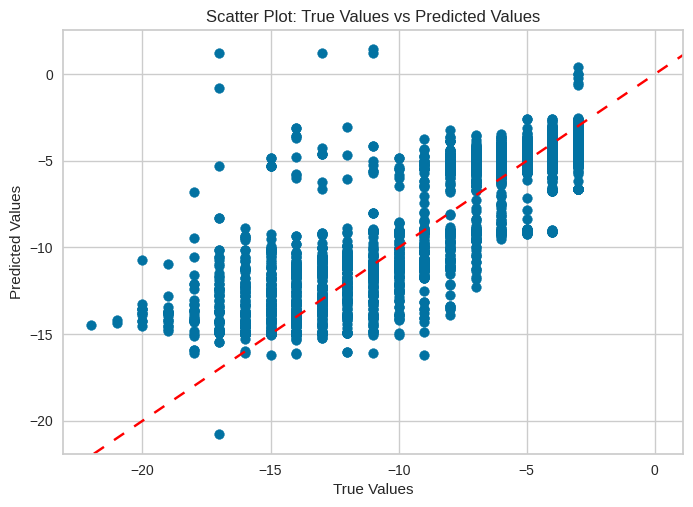


Decision Tree Regressor:


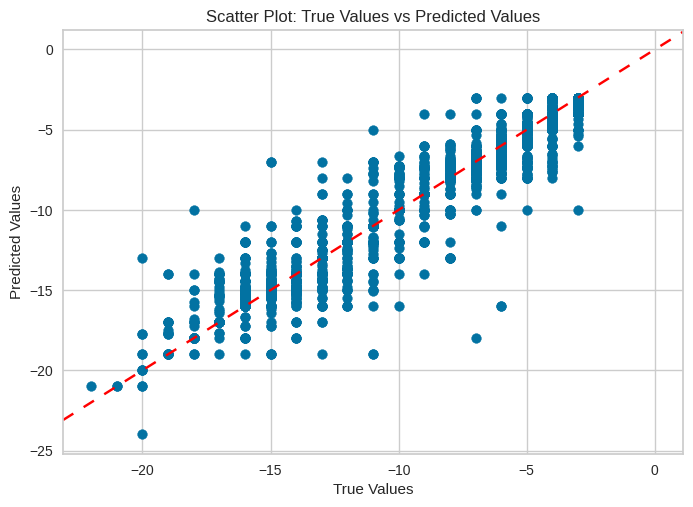


Random Forest Regressor:


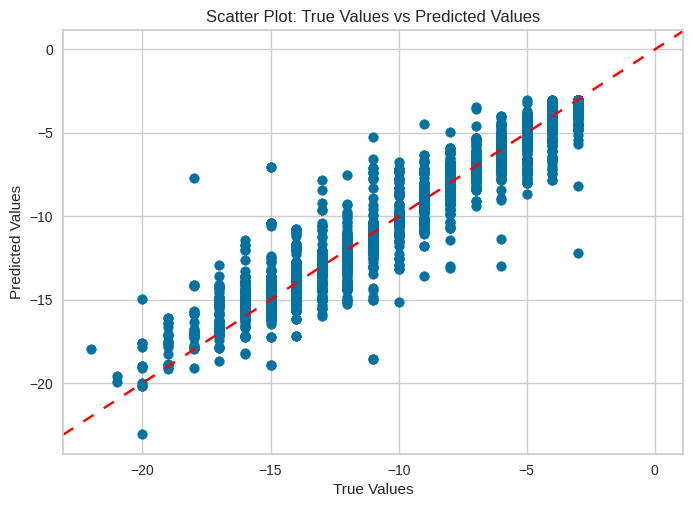

In [17]:
print("Support Vector Regressor:")
plot_scatter_plot(y_test, y_pred_svr)

print("\nDecision Tree Regressor:")
plot_scatter_plot(y_test, y_pred_dtr)

print("\nRandom Forest Regressor:")
plot_scatter_plot(y_test, y_pred_rfr)

Observamos como que no SVR possui um plot de dispersão muito mais disperso que o DTR e RFR. Se fossemos comparar os vários plots e métricas geradas, concluimos que o RFR possui um melhor desempenho na regressão da intensidade do sinal.

# 3º Desafio: Predição do tipo de mobilidade


Para esta etapa, interpretamos o problema como um problema de classificação multiclasse, o qual resolveremos utilizando inteligência artificial. Neste caso utilizaremos o modelo probabilístico Random Forest.


##Obtendo os dados

In [18]:
datasets = [ os.path.join(GNETTRACKPRO_PATH, file) for file in os.listdir(GNETTRACKPRO_PATH) ]

datasetsData = []
labels = ["walking", "subway", "driving", "indoor"]
display(datasets)
for dataset in datasets:
  if dataset != "../datasets/g-nettrack-pro/2023-02-24_16-35.txt":
    dt = pd.read_csv(dataset, sep='\t', low_memory=False, on_bad_lines='skip')
    for label in labels:
      if dataset.find(label)!= -1:
        dt['label'] = label
    datasetsData.append(dt)
gnetDf = pd.concat(datasetsData, ignore_index = True).copy()
display(gnetDf['label'])
gnetDf.drop(gnetDf.loc[gnetDf.Timestamp == 'Timestamp'].index, inplace=True)
gnetDf.Timestamp = pd.to_datetime(gnetDf.Timestamp, format='%Y.%m.%d_%H.%M.%S')
pd_insert_beside(gnetDf, 'Timestamp_seconds', gnetDf.Timestamp.astype(int) / 10**9)
gnetDf.sort_values('Timestamp', inplace=True, ignore_index=True)
gnetDf.replace({
    'Altitude': { '--': np.nan },
    'CHARGING': { 'true': True, 'false': False },
    **{ k: { '--': np.nan } for k in ['Longitude', 'Latitude', 'NetworkTech', 'Accuracy'] },
    **{ k: { '-': np.nan } for k in ['CQI', 'SNR', 'Qual', 'LTERSSI'] },
}, inplace=True)
gnetDf = gnetDf.astype({
    **{ k: 'string' for k in ['NetworkTech', 'NetworkMode', 'Location', 'State', 'EVENT', 'CGI', 'Node', 'CellID', 'LAC', 'Operatorname', 'Operator', 'IP'] },
    **{ k: np.float64 for k in ['Longitude', 'Latitude', 'Speed', 'Accuracy', 'SNR', 'Level', 'Qual', 'CQI', 'LTERSSI', 'ARFCN', 'DL_bitrate', 'UL_bitrate', 'PSC', 'Altitude', 'Height'] },
    **{ k: np.int32 for k in ['BATTERY'] },
})

gnetDf.replace({
    'Altitude': { 0: np.nan },
    'Height': { 0: np.nan, -10000: np.nan },
    'Speed': { -99: np.nan },
}, inplace=True)
gnetDf.head(5)

y = gnetDf ['label']
#gnetDf.drop('label', axis='columns', inplace=True)
X = gnetDf

['../datasets/g-nettrack-pro/2023-02-24_16-35.txt',
 '../datasets/g-nettrack-pro/2023-01-22_955-indoor-vila-petra-1.txt',
 '../datasets/g-nettrack-pro/2023-01-21_423-walking-paulista-3.txt',
 '../datasets/g-nettrack-pro/2023-01-21_555-walking-paulista-6.txt',
 '../datasets/g-nettrack-pro/2023-01-22_1004-driving-sp-2.txt',
 '../datasets/g-nettrack-pro/2023-01-21_404-indoor-shopping-cidade-sao-paulo-1.txt',
 '../datasets/g-nettrack-pro/2023-01-21_308-walking-paulista-1.txt',
 '../datasets/g-nettrack-pro/2023-01-21_244-subway-1.txt',
 '../datasets/g-nettrack-pro/2023-01-21_501-walking-paulista-4.txt',
 '../datasets/g-nettrack-pro/2023-01-21_435-indoor-starbucks-masp-1.txt',
 '../datasets/g-nettrack-pro/2023-01-22_933-driving-sp-1.txt',
 '../datasets/g-nettrack-pro/2023-01-21_345-walking-paulista-2.txt',
 '../datasets/g-nettrack-pro/2023-01-21_517-walking-paulista-5.txt']

0         indoor
1         indoor
2         indoor
3         indoor
4         indoor
          ...   
18353    walking
18354    walking
18355    walking
18356    walking
18357    walking
Name: label, Length: 18358, dtype: object

## Preprocessamento




O preprocessamento dos dados é uma etapa extremamente necessária para a obtenção de melhores em classificações utilizando IA. Neste trabalho o preprocessamento foi feito realizando as seguintes etapas:


### Remoção de colunas sem valores

In [19]:
dataframe = X

dataframe = dataframe.dropna(axis=1, how='all')
display(dataframe)

Timestamp  Timestamp_seconds  Longitude   Latitude  Speed  \
0     2023-01-21 14:44:46       1674312286.0        NaN        NaN    NaN   
1     2023-01-21 14:44:46       1674312286.0        NaN        NaN    NaN   
2     2023-01-21 14:44:47       1674312287.0        NaN        NaN    NaN   
3     2023-01-21 14:44:48       1674312288.0        NaN        NaN    NaN   
4     2023-01-21 14:44:49       1674312289.0        NaN        NaN    NaN   
...                   ...                ...        ...        ...    ...   
18352 2023-01-22 22:31:02       1674426662.0 -46.728399 -23.595755    0.0   
18353 2023-01-22 22:31:03       1674426663.0 -46.728399 -23.595755    0.0   
18354 2023-01-22 22:31:04       1674426664.0 -46.728399 -23.595755    0.0   
18355 2023-01-22 22:31:05       1674426665.0 -46.728399 -23.595755    0.0   
18356 2023-01-22 22:31:05       1674426665.0 -46.728399 -23.595755    0.0   

      Operatorname Operator              CGI    Node CellID    LAC  \
0         CLARO_BR    72405  724056481100018  113726     18  64811   
1         CLARO_BR    72405  724056481100018  113726     18  64811   
2         CLARO_BR    72405  724056481100018  113726     18  64811   
3         CLARO_BR    72405  724056481100017  113726     17  64811   
4         CLARO_BR    72405  724056481100017  113726     17  64811   
...            ...      ...              ...     ...    ...    ...   
18352     CLARO_BR    72405  724054571100003  111825      3  45711   
18353     CLARO_BR    72405  724054571100003  111825      3  45711   
18354     CLARO_BR    72405  724054571100003  111825      3  45711   
18355     CLARO_BR    72405  724054571100003  111825      3  45711   
18356     CLARO_BR    72405  724054571100003  111825      3  45711   

      NetworkTech NetworkMode  Level  Qual  SNR  CQI  LTERSSI  ARFCN  \
0              4G         LTE -112.0  -8.0 17.0 14.0    -65.0 1400.0   
1              4G         LTE -110.0  -8.0 16.0 14.0    -61.0 1400.0   
2              4G         LTE -112.0  -8.0 17.0 14.0    -65.0 1400.0   
3              4G         LTE -109.0  -8.0  4.0  6.0    -59.0 1400.0   
4              4G         LTE -109.0  -8.0  4.0  6.0    -59.0 1400.0   
...           ...         ...    ...   ...  ...  ...      ...    ...   
18352          4G         LTE -108.0 -17.0 -2.0 10.0   -109.0 2950.0   
18353          4G         LTE -108.0 -17.0 -2.0 10.0   -109.0 2950.0   
18354          4G         LTE -107.0 -16.0 -2.0 10.0   -105.0 2950.0   
18355          4G         LTE -107.0 -16.0 -2.0 10.0   -105.0 2950.0   
18356          4G         LTE -107.0 -16.0 -2.0 10.0   -105.0 2950.0   

       DL_bitrate  UL_bitrate   PSC  Altitude  Height  Accuracy Location  \
0           119.0        53.0 111.0       NaN     NaN       NaN     <NA>   
1            25.0        29.0 111.0       NaN     NaN       NaN     <NA>   
2            15.0         2.0 111.0       NaN     NaN       NaN     <NA>   
3             0.0         0.0 103.0       NaN     NaN       NaN     <NA>   
4             0.0         0.0 103.0       NaN     NaN       NaN     <NA>   
...           ...         ...   ...       ...     ...       ...      ...   
18352        53.0        56.0 305.0     779.0   779.0       4.0        G   
18353        43.0        29.0 305.0     779.0   779.0       4.0        G   
18354        70.0       158.0 305.0     779.0   779.0       4.0        G   
18355      3309.0       144.0 305.0     779.0   779.0       4.0        G   
18356      3309.0       144.0 305.0     779.0   779.0       4.0        G   

      State DataConnection_Type DataConnection_Info Layer Distance Bearing  \
0         D                   M                  13     1        0       0   
1         D                   M                  13     1        0       0   
2         D                   M                  13     1        0       0   
3         D                   M                  13     1        0       0   
4         I                   M                  13     1        0       0   
... 

### Discretização de Valores Não-Numéricos

In [20]:
for column in dataframe.select_dtypes(include=['object', "string", "datetime"]):
    codes, uniques = pd.factorize(dataframe[column])
    dataframe[column] = codes

<ipython-input-20-1a038ec4dc40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column] = codes
<ipython-input-20-1a038ec4dc40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column] = codes
<ipython-input-20-1a038ec4dc40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

### Imputar Valores Vazios

In [21]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10, weights="uniform")
columns = dataframe.columns

imputed_data = imputer.fit_transform(dataframe)
dataframe = pd.DataFrame(imputed_data, columns=columns)
dataframe.to_csv("imputed_df.csv", index=True)

#dataframe = pd.read_csv("imputed_df.csv")
#dataframe = dataframe[dataframe.columns[1:]]

display(dataframe.head(10))

Timestamp  Timestamp_seconds  Longitude   Latitude  Speed  Operatorname  \
0        0.0       1674312286.0 -46.660623 -23.557382    2.7           0.0   
1        0.0       1674312286.0 -46.660623 -23.557382    2.7           0.0   
2        1.0       1674312287.0 -46.660623 -23.557382    2.7           0.0   
3        2.0       1674312288.0 -46.660623 -23.557382    2.7           0.0   
4        3.0       1674312289.0 -46.660623 -23.557382    2.7           0.0   
5        4.0       1674312290.0 -46.660623 -23.557382    2.7           0.0   
6        5.0       1674312291.0 -46.660623 -23.557382    2.7           0.0   
7        6.0       1674312292.0 -46.660623 -23.557382    2.7           0.0   
8        7.0       1674312293.0 -46.660623 -23.557382    2.7           0.0   
9        8.0       1674312294.0 -46.660623 -23.557382    2.7           0.0   

   Operator  CGI  Node  CellID  LAC  NetworkTech  NetworkMode  Level  Qual  \
0       0.0  0.0   0.0     0.0  0.0          0.0          0.0 -112.0  -8.0   
1       0.0  0.0   0.0     0.0  0.0          0.0          0.0 -110.0  -8.0   
2       0.0  0.0   0.0     0.0  0.0          0.0          0.0 -112.0  -8.0   
3       0.0  1.0   0.0     1.0  0.0          0.0          0.0 -109.0  -8.0   
4       0.0  1.0   0.0     1.0  0.0          0.0          0.0 -109.0  -8.0   
5       0.0  1.0   0.0     1.0  0.0          0.0          0.0 -109.0  -8.0   
6       0.0  1.0   0.0     1.0  0.0          0.0          0.0 -109.0  -8.0   
7       0.0  1.0   0.0     1.0  0.0          0.0          0.0 -108.0  -5.0   
8       0.0  1.0   0.0     1.0  0.0          0.0          0.0 -108.0  -5.0   
9       0.0  1.0   0.0     1.0  0.0          0.0          0.0 -106.0  -6.0   

   SNR  CQI  LTERSSI  ARFCN  DL_bitrate  UL_bitrate   PSC  Altitude  Height  \
0 17.0 14.0    -65.0 1400.0       119.0        53.0 111.0     817.9   817.9   
1 16.0 14.0    -61.0 1400.0        25.0        29.0 111.0     817.9   817.9   
2 17.0 14.0    -65.0 1400.0        15.0         2.0 111.0     817.9   817.9   
3  4.0  6.0    -59.0 1400.0         0.0         0.0 103.0     817.9   817.9   
4  4.0  6.0    -59.0 1400.0         0.0         0.0 103.0     817.9   817.9   
5  5.0  6.0    -59.0 1400.0         0.0         0.0 103.0     817.9   817.9   
6  5.0  6.0    -59.0 1400.0         0.0         0.0 103.0     817.9   817.9   
7  3.0 13.0    -63.0 1400.0         0.0         5.0 103.0     817.9   817.9   
8  3.0 13.0    -63.0 1400.0       332.0        42.0 103.0     817.9   817.9   
9 22.0 14.0    -59.0 1400.0       498.0       120.0 103.0     817.9   817.9   

   Accuracy  Location  State  DataConnection_Type  DataConnection_Info  Layer  \
0       7.8      -1.0    0.0                  0.0                  0.0    0.0   
1       7.8      -1.0    0.0                  0.0                  0.0    0.0   
2       7.8      -1.0    0.0                  0.0                  0.0    0.0   
3       7.8      -1.0    0.0                  0.0                  0.0    0.0   
4       7.8      -1.0    1.0                  0.0                  0.0    0.0   
5       7.8      -1.0    1.0                  0.0                  0.0    0.0   
6       7.8      -1.0    1.0                  0.0                  0.0    0.0   
7       7.8      -1.0    0.0                  0.0                  0.0    0.0   
8       7.8      -1.0    0.0                  0.0                  0.0    0.0   
9       7.8      -1.0    0.0                  0.0                  0.0    0.0   

   Distance  Bearing  IP   TA  EVENT  EVENTDETAILS  SERVINGTIME  CELLHEX  \
0       0.0      0.0 0.0  0.0    0.0          -1.0          0.0      0.0   
1       0.0      0.0 0.0  0.0    1.0          -1.0          1.0      0.0   
2       0.0      0.0 0.0  0.0    0.0          -1.0          2.0      0.0   
3       0.0      0.0 0.0 -1.0    2.0           0.0          2.0      1.0   
4       0.0      0.0 0.0  1.0    0.0          -1.0          3.0      1.0   
5       0.0      0.0 0.0  1.0    0.0          -1.0          4.0    

### Normalização de Dados

In [22]:
from sklearn import preprocessing

dataframe_values = dataframe.values
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(dataframe_values)
dataframe = pd.DataFrame(df_scaled, columns=columns)

display(dataframe.head(10))

Timestamp  Timestamp_seconds  Longitude  Latitude    Speed  Operatorname  \
0        0.0                0.0   0.835635  0.485790 0.035526           0.0   
1        0.0                0.0   0.835635  0.485790 0.035526           0.0   
2   0.000065           0.000009   0.835635  0.485790 0.035526           0.0   
3   0.000130           0.000017   0.835635  0.485790 0.035526           0.0   
4   0.000196           0.000026   0.835635  0.485790 0.035526           0.0   
5   0.000261           0.000035   0.835635  0.485790 0.035526           0.0   
6   0.000326           0.000044   0.835635  0.485790 0.035526           0.0   
7   0.000391           0.000052   0.835635  0.485790 0.035526           0.0   
8   0.000456           0.000061   0.835635  0.485790 0.035526           0.0   
9   0.000522           0.000070   0.835635  0.485790 0.035526           0.0   

   Operator      CGI     Node   CellID  LAC  NetworkTech  NetworkMode  \
0       0.0      0.0 0.012048      0.0  0.0     0.333333          0.0   
1       0.0      0.0 0.012048      0.0  0.0     0.333333          0.0   
2       0.0      0.0 0.012048      0.0  0.0     0.333333          0.0   
3       0.0 0.017241 0.012048 0.052632  0.0     0.333333          0.0   
4       0.0 0.017241 0.012048 0.052632  0.0     0.333333          0.0   
5       0.0 0.017241 0.012048 0.052632  0.0     0.333333          0.0   
6       0.0 0.017241 0.012048 0.052632  0.0     0.333333          0.0   
7       0.0 0.017241 0.012048 0.052632  0.0     0.333333          0.0   
8       0.0 0.017241 0.012048 0.052632  0.0     0.333333          0.0   
9       0.0 0.017241 0.012048 0.052632  0.0     0.333333          0.0   

     Level     Qual      SNR      CQI  LTERSSI    ARFCN  DL_bitrate  \
0 0.671498 0.761905     0.74 0.928571 0.774194 0.122863    0.000668   
1 0.681159 0.761905     0.72 0.928571 0.838710 0.122863    0.000140   
2 0.671498 0.761905     0.74 0.928571 0.774194 0.122863    0.000084   
3 0.685990 0.761905 0.480000 0.357143 0.870968 0.122863         0.0   
4 0.685990 0.761905 0.480000 0.357143 0.870968 0.122863         0.0   
5 0.685990 0.761905      0.5 0.357143 0.870968 0.122863         0.0   
6 0.685990 0.761905      0.5 0.357143 0.870968 0.122863         0.0   
7 0.690821 0.904762     0.46 0.857143 0.806452 0.122863         0.0   
8 0.690821 0.904762     0.46 0.857143 0.806452 0.122863    0.001864   
9 0.700483 0.857143 0.840000 0.928571 0.870968 0.122863    0.002797   

   UL_bitrate      PSC  Altitude   Height  Accuracy  Location  State  \
0    0.042707 0.221557  0.538350 0.538350  0.030645       0.0    0.0   
1    0.023368 0.221557  0.538350 0.538350  0.030645       0.0    0.0   
2    0.001612 0.221557  0.538350 0.538350  0.030645       0.0    0.0   
3         0.0 0.205589  0.538350 0.538350  0.030645       0.0    0.0   
4         0.0 0.205589  0.538350 0.538350  0.030645       0.0    1.0   
5         0.0 0.205589  0.538350 0.538350  0.030645       0.0    1.0   
6         0.0 0.205589  0.538350 0.538350  0.030645       0.0    1.0   
7    0.004029 0.205589  0.538350 0.538350  0.030645       0.0    0.0   
8    0.033844 0.205589  0.538350 0.538350  0.030645       0.0    0.0   
9    0.096696 0.205589  0.538350 0.538350  0.030645       0.0    0.0   

   DataConnection_Type  DataConnection_Info  Layer  Distance  Bearing  IP  \
0                  0.0                  0.0    0.0       0.0      0.0 0.5   
1                  0.0                  0.0    0.0       0.0      0.0 0.5   
2                  0.0                  0.0    0.0       0.0      0.0 0.5   
3                  0.0                  0.0    0.0       0.0      0.0 0.5   
4                  0.0                  0.0    0.0       0.0      0.0 0.5   
5                  0.0                  0.0    0.0       0.0      0.0 0.5   
6                  0.0                  0.0    0.0       0.0      0.0 0.5   
7                  0.0                  0.0    0.0       0.0      0.0 0.5   
8                  0.0                  0.0    0.0       0.0 

## Classificação com Random Forest


### Ranqueamento de Features Mais Relevantes

In [23]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, step=1,  n_features_to_select=5)

codes, uniques = pd.factorize(y)
y = codes

selector = selector.fit(dataframe, y)

selector.ranking_

array([118,  12,   3,   2,  64, 181, 180, 130, 100, 116,   1,  88, 156,
        82,  83, 140, 167, 144,  85, 145, 177,  84, 153, 159, 108,   9,
       135, 178,  18,  11,   6,   1,   7, 168, 150, 169,  91, 128,  90,
         1, 155,  10,   8, 179, 123, 149,  87,  93, 117, 170, 173,  80,
       171,  81, 162, 160,   1,  13, 182, 126, 138, 104, 103, 141, 175,
       143,  30,  31,  44, 151, 125, 142, 174,  26,  27,  49, 157, 165,
       166, 137,  28,  29,  45, 133, 136, 107, 110,  79,  70,  69, 109,
       113, 124, 101,  75,  68,  67, 152, 161, 132, 131,  73,  61,  60,
       164, 106, 121, 112,  76,  72,  71, 105, 172, 147, 134,  77,  66,
        65, 102, 158, 122, 148,  57,  55,  37,  92,  86, 176, 120,  62,
        56,  47, 115, 119,  58,  63,  94,   5,   4,  89, 114,  35,  95,
        53,  17,  14,  78, 127,  74,  96,  52,  33,  16, 129, 146, 111,
        15,  59,  24,  19, 139, 163, 154,  25,  54,  32,  21,  97,  98,
        99,  22,  41,  34,  23,  43,  46,  51,  36,  38,  39,  4

In [24]:
ranking = list (zip(dataframe.columns, selector.ranking_))
ranking.sort(key=lambda a: a[1])
print(ranking)


[('LAC', 1), ('Bearing', 1), ('LACHEX', 1), ('Site_BEARING', 1), ('label', 1), ('Latitude', 2), ('Longitude', 3), ('NLAC12', 4), ('NCellid12', 5), ('Distance', 6), ('IP', 7), ('VERSION_CODE', 8), ('Location', 9), ('VERSION_NAME', 10), ('Layer', 11), ('Timestamp_seconds', 12), ('BATTERY', 13), ('NLAC13', 14), ('NQual14', 15), ('NLAC14', 16), ('NCellid13', 17), ('DataConnection_Info', 18), ('NLAC15', 19), ('NQual18', 20), ('NLAC16', 21), ('NQual16', 22), ('NLAC17', 23), ('NCellid15', 24), ('NQual15', 25), ('NTech3', 26), ('NCellid3', 27), ('NTech4', 28), ('NCellid4', 29), ('NTech2', 30), ('NCellid2', 31), ('NCellid16', 32), ('NCellid14', 33), ('NCellid17', 34), ('NRxLev12', 35), ('NQual17', 36), ('NLAC10', 37), ('NTech18', 38), ('NCellid18', 39), ('NLAC18', 40), ('NTech17', 41), ('NCell18', 42), ('NCell17', 43), ('NLAC2', 44), ('NLAC4', 45), ('NARFCN17', 46), ('NLAC11', 47), ('NARFCN18', 48), ('NLAC3', 49), ('NRxLev18', 50), ('NRxLev17', 51), ('NTech14', 52), ('NTech13', 53), ('NTech16',

In [27]:
best_param = []
for pair in ranking:
  if pair[1]<25 and pair[0]!='label':
    best_param.append(pair[0])

best_data = dataframe[best_param]
display(best_data)

LAC  Bearing  LACHEX  Site_BEARING  Latitude  Longitude  NLAC12  \
0      0.0      0.0     0.0           0.0  0.485790   0.835635     0.0   
1      0.0      0.0     0.0           0.0  0.485790   0.835635     0.0   
2      0.0      0.0     0.0           0.0  0.485790   0.835635     0.0   
3      0.0      0.0     0.0           0.0  0.485790   0.835635     0.0   
4      0.0      0.0     0.0           0.0  0.485790   0.835635     0.0   
...    ...      ...     ...           ...       ...        ...     ...   
18352 0.75 0.333333    0.75      0.333333       0.0   0.185865     0.0   
18353 0.75 0.333333    0.75      0.333333       0.0   0.185865     0.0   
18354 0.75 0.333333    0.75      0.333333       0.0   0.185865     0.0   
18355 0.75 0.333333    0.75      0.333333       0.0   0.185865     0.0   
18356 0.75 0.333333    0.75      0.333333       0.0   0.185865     0.0   

       NCellid12  Distance  IP  VERSION_CODE  Location  VERSION_NAME  Layer  \
0            0.0       0.0 0.5           0.0       0.0           0.0    0.0   
1            0.0       0.0 0.5           0.0       0.0           0.0    0.0   
2            0.0       0.0 0.5           0.0       0.0           0.0    0.0   
3            0.0       0.0 0.5           0.0       0.0           0.0    0.0   
4            0.0       0.0 0.5           0.0       0.0           0.0    0.0   
...          ...       ...  ..           ...       ...           ...    ...   
18352        0.0  0.333333 1.0           0.0       1.0           0.0    0.0   
18353        0.0  0.333333 1.0           0.0       1.0           0.0    0.0   
18354        0.0  0.333333 1.0           0.0       1.0           0.0    0.0   
18355        0.0  0.333333 1.0           0.0       1.0           0.0    0.0   
18356        0.0  0.333333 1.0           0.0       1.0           0.0    0.0   

       Timestamp_seconds  BATTERY  NLAC13  NQual14  NLAC14  NCellid13  \
0                    0.0      0.9     0.0      0.0     0.0        0.0   
1                    0.0      0.9     0.0      0.0     0.0        0.0   
2               0.000009      0.9     0.0      0.0     0.0        0.0   
3               0.000017      0.9     0.0      0.0     0.0        0.0   
4               0.000026      0.9     0.0      0.0     0.0        0.0   
...                  ...      ...     ...      ...     ...        ...   
18352           0.999974 0.844444     0.0      0.0     0.0        0.0   
18353           0.999983 0.844444     0.0      0.0     0.0        0.0   
18354           0.999991 0.844444     0.0      0.0     0.0        0.0   
18355                1.0 0.844444     0.0      0.0     0.0        0.0   
18356                1.0 0.844444     0.0      0.0     0.0        0.0   

       DataConnection_Info  NLAC15  NQual18  NLAC16  NQual16  NLAC17  \
0                      0.0     0.0      0.0     0.0      0.0     0.0   
1                      0.0     0.0      0.0     0.0      0.0     0.0   
2                      0.0     0.0      0.0     0.0      0.0     0.0   
3                      0.0     0.0      0.0     0.0      0.0     0.0   
4                      0.0     0.0      0.0     0.0      0.0     0.0   
...                    ...     ...      ...     ...      ...     ...   
18352                  0.0     0.0      0.0     0.0      0.0     0.0   
18353                  0.0     0.0      0.0     0.0      0.0     0.0   
18354                  0.0     0.0      0.0     0.0      0.0     0.0   
18355                  0.0     0.0      0.0     0.0      0.0     0.0   
18356                  0.0     0.0      0.0     0.0      0.0     0.0   

       NCellid15  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
...          ...  
18352        0.0  
18353        0.0  
18354        0.0  
18355        0.0  
18356        0.0  

[18357 rows x 27 columns]


### Treinamento, predição e métricas

In [28]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,  cross_val_predict
from sklearn.metrics import classification_report

# Criar o classificador Random Forest
clf = RandomForestClassifier()

# Realizar validação cruzada
y_pred = cross_val_predict(clf, best_data, y, cv=5)  # cv=5 para 5-fold cross-validation

display(y_pred)

classification_rep = classification_report(y, y_pred)
print("Métricas de Classificação:")
print(classification_rep)

array([0, 0, 0, ..., 3, 3, 3])

Métricas de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       676
           1       0.98      0.82      0.89     10270
           2       0.56      0.82      0.66      2946
           3       0.93      0.98      0.95      4465

    accuracy                           0.87     18357
   macro avg       0.87      0.91      0.88     18357
weighted avg       0.90      0.87      0.88     18357



Como pode-se ver pelos resultados do report da classificação, foi possível obter uma classificação com F1-score em torno dos 90% 

### Matriz de confusão

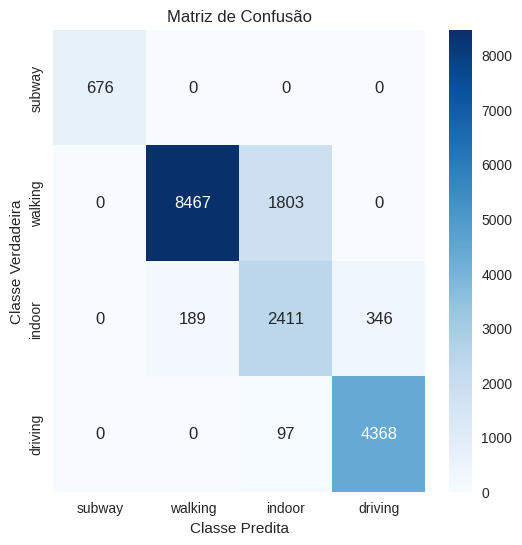

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = confusion_matrix(y, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["subway", "walking", "indoor", "driving"],
            yticklabels=["subway", "walking", "indoor", "driving"])
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

Com base na matriz de confusão, pode-se observar que a maior confusão ocorreu entre as classes "walking" (caminhando) e "indoor" (dentro de um ambiente fechado), o que é compreensível, uma vez que ambas envolvem a locomoção de pedestres. Apesar desse caso, a taxa de falsas predições foi relativamente baixa em geral, o que está de acordo com os dados apresentados no relatório de classificação.
Também é possivel notar que foi possível classificar 100% dos casos de "subway"(trem/metrô) corretamente.

#5º Inferir a qual Célula/Estação Rádio Base um celular está conectado

In [30]:
import zipfile
import pandas as pd
import requests
from io import BytesIO

# URL do arquivo zip
url = 'https://github.com/intrig-unicamp/hackathon5G/raw/main/datasets/mosaico/mosaico-erbs-s%C3%A3o-paulo.zip'

# Faz o download do arquivo zip
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Extrai o conteúdo do arquivo zip em uma pasta temporária
zip_file.extractall('./')

Este trecho de código é responsável por filtrar apenas as estações "Claro S.A." detre o conjunto de dados de todas as antenas do mosaico. 

In [31]:
import pandas as pd

# read the "antenas_sp.csv" file with pandas
# header is the first line of the file
infos_antenas = pd.read_csv('csv_licenciamento_a6f62d75da62697abd60961cc90a7e93.csv', sep=',', header=0, encoding='ISO-8859-1')

# filter NomeEntidade column keeping only the rows with "CLARO S.A."
infos_antenas = infos_antenas[infos_antenas['NomeEntidade'] == 'CLARO S.A.']

print(infos_antenas.head())

# save in filtered_antenas_sp.csv
infos_antenas.to_csv('mosaico_sp_claro.csv', index=False)

<ipython-input-31-87de981e4bfe>:5: DtypeWarning: Columns (7,11,12,16,18,19,21,23,24,25,27,28,29,39) have mixed types. Specify dtype option on import or set low_memory=False.
  infos_antenas = pd.read_csv('csv_licenciamento_a6f62d75da62697abd60961cc90a7e93.csv', sep=',', header=0, encoding='ISO-8859-1')


    Status.state NomeEntidade    NumFistel  NumServico     NumAto  NumEstacao  \
200   LIC-LIC-01   CLARO S.A.  50409105090          10 46662011.0     1246232   
201   LIC-LIC-01   CLARO S.A.  50409105090          10 46662011.0     1246232   
202   LIC-LIC-01   CLARO S.A.  50409105090          10 46662011.0     1246232   
203   LIC-LIC-01   CLARO S.A.  50409105090          10 46662011.0     1246232   
204   LIC-LIC-01   CLARO S.A.  50409105090          10 46662011.0     1246232   

                EnderecoEstacao EndComplemento SiglaUf  CodMunicipio  \
200  R GASPAR GONÇALVES RIBEIRO              0      SP       3550308   
201  R GASPAR GONÇALVES RIBEIRO              0      SP       3550308   
202  R GASPAR GONÇALVES RIBEIRO              0      SP       3550308   
203  R GASPAR GONÇALVES RIBEIRO              0      SP       3550308   
204  R GASPAR GONÇALVES RIBEIRO              0      SP       3550308   

    DesignacaoEmissao Tecnologia tipoTecnologia  meioAcesso  FreqTxMHz  \
200   

Em seguida carregamos o arquivo com as antenas filtradas, juntamente com o arquivo de coleta de dados de um dispositivo

In [32]:
import pandas as pd

from math import radians

from math import radians, sin, cos, sqrt, atan2

infos_antenas = pd.read_csv('mosaico_sp_claro.csv', sep=',', header=0, encoding='ISO-8859-1', low_memory=False)

dispositivo = pd.read_csv("https://raw.githubusercontent.com/intrig-unicamp/hackathon5G/main/datasets/g-nettrack-pro/2023-01-21_308-walking-paulista-1.txt", sep='	', header=0, encoding='ISO-8859-1', low_memory=False)

Com isso selecionamos a primeira lista de dados do dataset e convertemos ela em um array

In [33]:
dispositivo = dispositivo.head(1)

dispositivo = dispositivo.values

Agora definimos uma função responsável por calcula a distância entre dois pontos geográficos utilizando o método haversine. A função recebe duas coordenadas geográficas e retorna a distância entre as coordenadas em metros.

In [34]:
def haversine_distances(coord1, coord2):
    # calcule a distância entre as duas coordenadas em m
    # raio da terra em km
    R = 6373000

    # convert degrees to radians
    lat1 = radians(coord1[0])
    lon1 = radians(coord1[1])
    lat2 = radians(coord2[0])
    lon2 = radians(coord2[1])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2

    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

Com isso resgatamos as coordenadas do dispositivo

In [35]:
target_coordinates = dispositivo[0][2], dispositivo[0][1]

antenas = infos_antenas

E então para cada antena no conjunto de dados, calculamos a distância entre a antena e o dispositivo e adicionamos esta informação ao dataframe com rótulo "Distância"

In [36]:
for index, row in antenas.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    distancia = haversine_distances((latitude, longitude), target_coordinates)
    antenas.at[index, 'Distancia'] = distancia

Com as distâncias calculadas, ordenamos as antenas com base na distância entre a antena e o dispositivo.

In [37]:
antenas = antenas.sort_values(by=['Distancia'])

Resgatamos o número da estação mais pŕoxima e a distância dessa estação até o dispositivo.

In [38]:
antenas = antenas.head(1)
num_estacao = antenas['NumEstacao'].values[0]
distancia = antenas['Distancia'].values[0]

Agora definimos uma função que calcula o angulo entre a direção em que a antena está apontando e a reta que passa entre o dispositivo e a estação.

In [39]:
import math

def calcular_angulo_entre_antena_e_ponto(angulo_antena, x1, y1, x2, y2):
    # Calcula a diferença nas coordenadas
    dx = x2 - x1
    dy = y2 - y1
    
    # Calcula o ângulo azimutal entre a antena e o ponto
    angulo_rad = math.atan2(dy, dx)
    
    # Calcula o ângulo entre a antena e o ponto
    angulo_entre_antena_e_ponto = angulo_rad - math.radians(float(angulo_antena))
    
    # Converte o ângulo para graus
    angulo_graus = math.degrees(angulo_entre_antena_e_ponto)
    
    return angulo_graus

Selecionamos todas as antenas da estação mais próxima

In [40]:
antenas_proximas = infos_antenas.loc[infos_antenas['NumEstacao'] == num_estacao]

E então para cada entena dentro da estação, calculamos o angulo entre a direção de cada antena e a linha entre a antena e o dispositivo. Após isso armazenamos o angulo em mais uma coluna no dataset, a coluna "Angulo"

In [41]:
for index, row in antenas_proximas.iterrows():
    #calcula o angulo da antena em relação ao dispositivo
    angulo_antena_dispositivo = calcular_angulo_entre_antena_e_ponto(row['Azimute'],dispositivo[0][2], dispositivo[0][1], row['Longitude'], row['Latitude'])
    # adiciona o angulo no dataframe
    antenas_proximas.at[index, 'Angulo'] = angulo_antena_dispositivo

<ipython-input-41-1d1eb514c47f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  antenas_proximas.at[index, 'Angulo'] = angulo_antena_dispositivo


Com isso basta ordenar as antenas com base nos respectivos ângulos.

In [42]:
antenas_proximas = antenas_proximas.sort_values(by=['Angulo'])

Recuperamos os valores do melhor angulo e o id da antena.

In [43]:
angulo_antena_dispositivo = antenas_proximas['Angulo'].values[0]
id_antena_dispositivo = antenas_proximas['_id'].values[0]

Por fim mostramos na tela todos os dados

In [44]:

print("Número da estação mais pŕoxima: "+str(num_estacao))
print("Distância: "+str(distancia))
print("Angulo da antena melhor orientada ao dispositivo: "+str(angulo_antena_dispositivo))
print("Id da antena da estação com o melhor angulo: "+str(id_antena_dispositivo))


Número da estação mais pŕoxima: 683887904
Distância: 111.87998149874693
Angulo da antena melhor orientada ao dispositivo: -90.00163038845893
Id da antena da estação com o melhor angulo: 5f31447daaf5f
